In [3]:
# If using dev, cd to the reconst file
# %cd dipy/dipy/reconst/
import numpy as np
from dipy.sims.voxel import multi_tensor
from dipy.data import get_data
from dipy.core.gradients import gradient_table
from dipy.io.gradients import read_bvals_bvecs
import matplotlib.pyplot as plt
import scipy.optimize as op
from ivim import ivim_function, IvimModel
import nibabel as nib
from dipy.core.sphere import disperse_charges, Sphere, HemiSphere

% matplotlib inline

In [4]:
def get_bvecs(N):
    """Generate bvectors for N bvalues"""
    theta = np.pi * np.random.rand(N)
    phi = 2 * np.pi * np.random.rand(N)
    hsph_initial = HemiSphere(theta=theta, phi=phi)
    hsph_updated, potential = disperse_charges(hsph_initial, 5000)
    vertices = hsph_updated.vertices
    return vertices

def generate_signal(gtab, S0, f, D_star, D, snr=None):
    mevals=np.array(([D_star, D_star, D_star],[D, D, D]))
    signal = multi_tensor(gtab, mevals, snr=snr, fractions=[f*100, 100*(1-f)])
    data = signal[0]
    return data

def simulate(f, D_star, D, snr=None):
    """This is a function to simulate and test the ivim model
    Takes parameter f, D_star, D and plots the predicted and actual signals"""
    bvals = np.array([0., 10., 20., 30., 40., 60., 80., 100.,
                      120., 140., 160., 180., 200., 220., 240.,
                      260., 280., 300., 350., 400., 500.,
                     600., 700., 800., 900, 1000.])
    
    N = len(bvals)
    bvecs = get_bvecs(N)
    gtab = gradient_table(bvals, bvecs.T)
    
    # Generate a signal
    S0 = 1.0
    data = generate_signal(gtab, S0, f, D_star, D)
    
    # Fit a model
    ivim_model = IvimModel(gtab)
    ivim_fit = ivim_model.fit(data)
    
    S0_est, f_est, D_star_est, D_est = ivim_fit.model_params
    estimated_signal = generate_signal(gtab, S0_est, f_est, D_star_est, D_est, snr)
    plot_signals(bvals, data, estimated_signal, ivim_fit.model_params, [S0, f, D_star, D])
    
    
def plot_signals(bvals, data, estimated_signal, est_params, act_params):
    """Plots """
    
    plt.scatter(bvals, estimated_signal, color = "red", label="Estimated signal")
    plt.scatter(bvals, data, color = "blue", label="Actual signal")
    plt.xlabel("bvalues")
    plt.ylabel("Signals")
    
    S0_est, f_est, D_star_est, D_est = est_params
    S0, f, D_star, D = act_params

    text_fit = 'Estimated \n S0={:06.3f} f={:06.4f}\nD*={:06.5f} D={:06.5f}'.format(S0_est, 
                                                                                    f_est, 
                                                                                    D_star_est, 
                                                                                    D_est)
    plt.text(0.65, 0.50, text_fit, horizontalalignment='center',
             verticalalignment='center', transform=plt.gca().transAxes)
    
    text_actual = 'Actual \n S0={:06.3f} f={:06.4f}\nD*={:06.5f} D={:06.5f}'.format(S0, 
                                                                                    f, 
                                                                                    D_star, 
                                                                                    D)
    plt.text(0.65, 0.75, text_actual, horizontalalignment='center',
          verticalalignment='center', transform=plt.gca().transAxes)
    
    error = "Mean error :{}".format(np.mean(estimated_signal-data))
    plt.text(0.65, 0.90, error, horizontalalignment='center',
          verticalalignment='center', transform=plt.gca().transAxes)
    
    plt.show()

/home/shahnawaz/dev/gsoc16/dipy/dipy/reconst/ivim.py:15: RuntimeWarning: overflow encountered in exp
  S = S0 * (f * np.exp(-bvals * D_star) + (1 - f) * np.exp(-bvals * D))
/home/shahnawaz/dev/gsoc16/dipy/dipy/reconst/ivim.py:15: RuntimeWarning: overflow encountered in multiply
  S = S0 * (f * np.exp(-bvals * D_star) + (1 - f) * np.exp(-bvals * D))


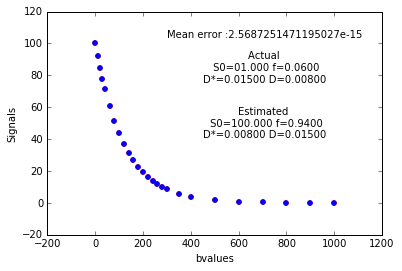

None


/home/shahnawaz/dev/gsoc16/dipy/dipy/reconst/ivim.py:15: RuntimeWarning: overflow encountered in exp
  S = S0 * (f * np.exp(-bvals * D_star) + (1 - f) * np.exp(-bvals * D))
/home/shahnawaz/dev/gsoc16/dipy/dipy/reconst/ivim.py:15: RuntimeWarning: overflow encountered in multiply
  S = S0 * (f * np.exp(-bvals * D_star) + (1 - f) * np.exp(-bvals * D))


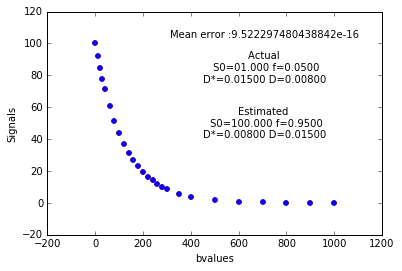

In [5]:
f, D_star, D = 0.06, 0.015, 0.008
print (simulate(f,D_star,D))

# Take a different fraction
f = 0.05
simulate(f,D_star,D)

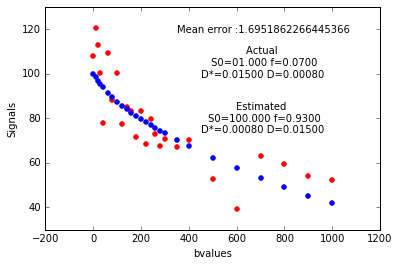

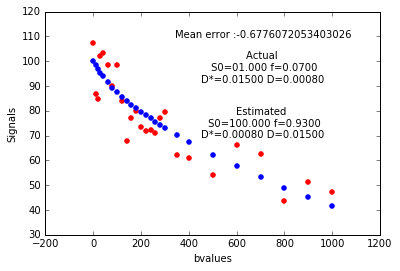

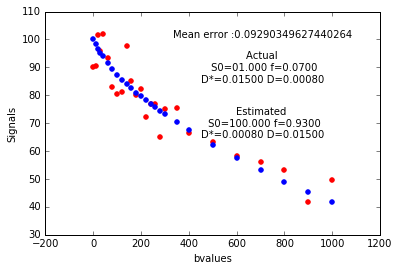

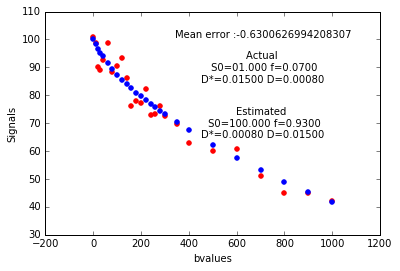

In [6]:
f, D_star, D = 0.07, 0.015, 0.0008
# Plot with various snr
simulate(f,D_star, D, snr=10)
simulate(f,D_star, D, snr=15)
simulate(f,D_star, D, snr=20)
simulate(f,D_star, D, snr=30)